# Useful segmentation tricks with the watershed transform

The watershed transform is a powerful and easy to use segmentation algorithm, and very reliable if an appropriate marker generation procedure can be created. In this notebook we introduce a variety of tricks that can be used when creating markers. We illustrate for the coins example, although they are useful in a variety of scenarios.

The takeaway points are:

1. Develop the markers in stages
1. Don't be scared to use large filters - making the image unreconisable usually doesn't matter during marker generation
1. Return to the original image when performing segmentation.

## Watershed transform background

The watershed transform using markers is a long established tool for segmentation that is introduced [here](https://scikit-image.org/docs/0.14.x/user_guide/tutorial_segmentation.html)

The important factors to understand about the watershed transform are:

1. Regions are grown from a set of "markers"
1. All image pixels are assigned to exactly one marker (or as a boundary) - that means that at least two marker classes are required to split the image into multiple regions
1. Boundaries between regions occur along ridge lines, or peaks, in the image topology (or midpoints of plateaus). There is no threshold step involved.
1. Markers lie entirely within the region to be segmented. Markers that cross region boundaries will lead to undesirable results.

## Plans

We're going to do things a bit differently to the other coin examples floating around. Firstly, we will pretend there isn't a reliable way of creating a background marker and  invest our effort in creating reliable foreground markers using big filters. We'll then perform two phases of watershed transform segmentation, the first of which will create our background markers.

# The problem

As in other examples using this image, the problem is to create an accurate, labelled, mask for each coin.

We begin with some setup and a look at the input data.


In [86]:

def image_show(image, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax.imshow(image, cmap=cmap)
    ax.axis('off')
    return fig, ax


def image_show_multi(imlist, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))
    i=0
    for r in range(nrows):
        for c in range(ncols):
            ax[i].imshow(imlist[i])
            ax[i].axis('off')
            i=i+1
            
    return fig, ax

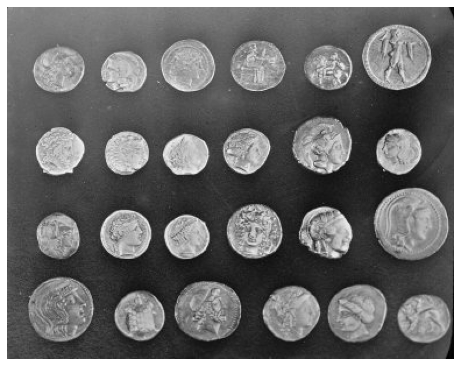

In [115]:
import numpy as np
import skimage
from skimage import data
import matplotlib.pyplot as plt
coins = data.coins()

a=image_show(coins)

# Foreground markers

Reliable segmentation using the watershed transform requires a single marker per coin. In addition, the marker must not cross the coin boundary.

We begin by making some observations about the scene we want to segment:

1. Coins are bright, but textured (see thresholding results in other tutorials)
1. Size varies, but not dramatically - the largest coin is probably about twice the diameter of the smallest.


Our first attempt at finding markers will be to apply a very large Gaussian smoothing, with a sigma value a substantial proportion of the size of the smallest coin, and find regional maxima (peaks) in that image.


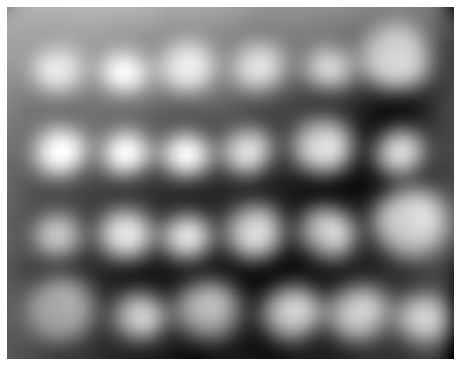

In [116]:
from skimage import filters
from skimage import morphology
from skimage import feature
from skimage import color
from skimage import measure
from skimage import segmentation

smoothed = skimage.filters.gaussian(coins, 10)
a=image_show(smoothed)

Now we find the local maxima (peaks) and dilate them.

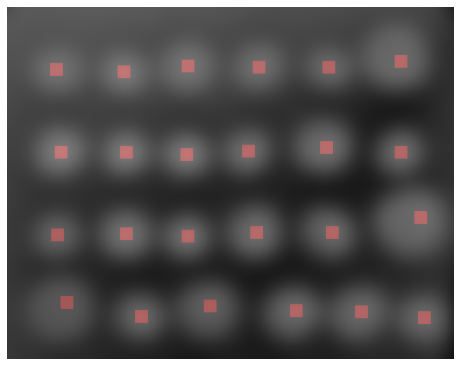

In [94]:
peak_idx = skimage.feature.peak_local_max(smoothed, min_distance=10)
peak_mask = np.zeros_like(smoothed, dtype=bool)
peak_mask[tuple(peak_idx.T)] = True
# dilate them and label
peak_mask = skimage.morphology.dilation(peak_mask, selem=skimage.morphology.square(11))
# display
peak_overlay = skimage.color.label2rgb(peak_mask, image=smoothed, bg_label=0)
a=image_show(peak_overlay)

Now we have a nice marker inside each coin. We've used the min distance parameter of `peak_local_max` in combination with the large smoothing kernel 
to reduce the chance of having multiple markers in a coin.

Now we need to create a marker for the background. We're going to do something a bit different this time - use the watershed to tesselate the scene, then take the boundary lines to use as markers in a second watershed.

The steps are:

1. Label the peak markers (record the number of peaks for later)
1. Invert the smoothed image
1. Apply a watershed that produces border regions
1. Select the boundary
1. Combine with the peak markers

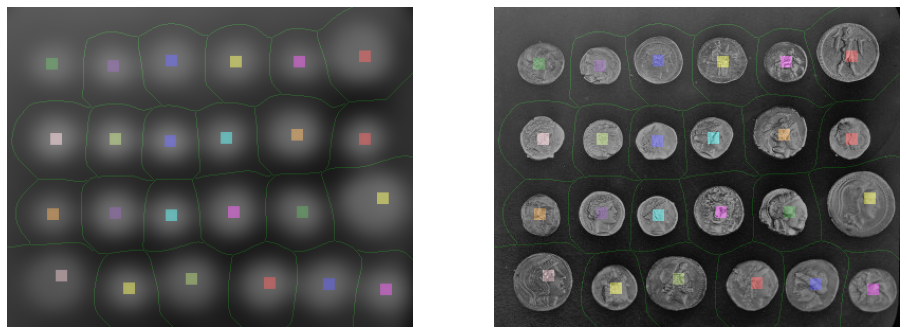

In [105]:
labelpeaks, totalpeaks = skimage.measure.label(peak_mask, return_num = True)

smoothed_inverted = np.max(smoothed) - smoothed
phase1seg = skimage.segmentation.watershed(image = smoothed_inverted, markers = labelpeaks, watershed_line = True) 
newmarkers = (phase1seg == 0)*(totalpeaks + 1) + labelpeaks

newmarkers_overlay = skimage.color.label2rgb(newmarkers, image=smoothed, bg_label=0)
newmarkers_overlay_orig = skimage.color.label2rgb(newmarkers, image=coins, bg_label=0)
a=image_show_multi([newmarkers_overlay, newmarkers_overlay_orig], nrows=1, ncols=2)

Check that it looks OK on the original image - all background markers (green) are between coins and foreground markers are inside coins.

Note that the textures inside the coins are likely to cause trouble for our edge operators.

Now we create an edge image for the second phase of segmentation. skimage doesn't have derivative of Gaussian functions so we'll smooth then apply Sobel filters instead. A substantial smoothing reduces the chances of holes in the gradient, with the side effect of removing high frequency components. However the outer edges of the coins are smooth so smoothing doesn't matter much.

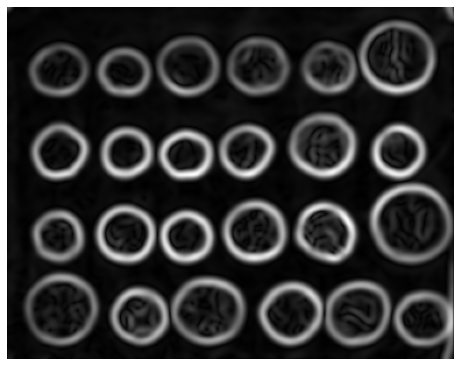

In [112]:
edges = skimage.filters.gaussian(coins, 3)
edges = skimage.filters.sobel(edges)
a=image_show(edges)

Finally we apply a watershed

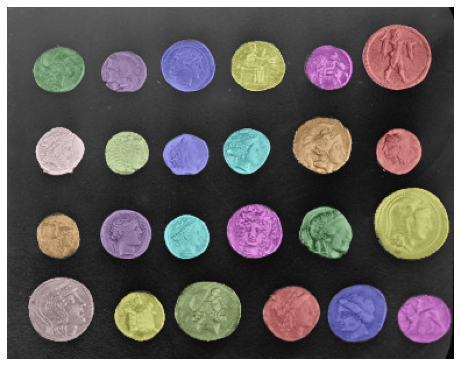

In [114]:
finalseg = skimage.segmentation.watershed(edges, newmarkers, watershed_line = False)
# remove the background segmentation
finalseg[finalseg == (totalpeaks + 1)] = 0
# display
finalseg_overlay = skimage.color.label2rgb(finalseg, image=coins, bg_label=0)
a = image_show(finalseg_overlay)